---
# Projeto I - MLP

In [1]:
# Bibliotecas utilizadas
from src.mlp import MLP

from math import ceil, log
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
def projeto(X_data:pd.DataFrame, y_data:pd.DataFrame,
        eta:list=[0.01, 0.5, 0.99], alpha:list=[0, 0.5, 1],
        test_size:float=0.3, n_intermed:int=1,
        neur_intermed:int=10, max_epocas:int=50, seed=42):
    X_data, y_data = np.array(X_data), np.array(y_data)
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=test_size, random_state=seed, shuffle=True)
    print('treino', X_train.shape, y_train.shape)
    print('teste', X_test.shape, y_test.shape)

    fig, axs = plt.subplots(len(eta), len(alpha), sharex=True, sharey=True)
    fig.set_figheight(2*len(eta))
    fig.set_figwidth(4*len(alpha))

    camadas = [len(X_train[0])]
    camadas += [neur_intermed for _ in range(n_intermed)]
    camadas += [len(y_train[0])]
    for i, eta_i in enumerate(eta):
        for j, alpha_i in enumerate(alpha):
            rede = MLP(camadas=camadas,seed=seed)
            err = rede.treino(X=X_train, Y=y_train, taxa=eta_i, alpha=alpha_i, max_epocas=max_epocas)
            MSE = rede.teste(X=X_test, Y=y_test)
            axs[i,j].set_title('eta:{:.1f}    alpha:{:.1f}'.format(eta_i, alpha_i))
            axs[i,j].plot(err)
            axs[i,j].plot(len(err)-1, MSE, ls=None, marker='x', c='red')
            print('eta:{:.1f}    alpha:{:.1f}    MSE(treino):{:.5f}    MSE(teste):{:.5f}'.format(eta_i, alpha_i, err[-1], MSE))
    plt.show()

    return

In [3]:
# debug
def debug(data, X_data, y_data, tam_resp, camadas:list, n_tests:int=20,  seed:int=321):
    X_data, y_data = np.array(X_data), np.array(y_data)
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=seed, shuffle=True)
    rede = MLP(camadas=camadas)
    _ = rede.treino(X=X_data, Y=y_data, taxa=0.5, alpha=0.5, max_epocas=100)

    debug = np.random.randint(size=n_tests, low=0, high=len(data))
    for v in debug:
        debug_x = [np.array(data.iloc[v,:-tam_resp])]
        debug_y = [np.array(data.iloc[v,-tam_resp:])]
        
        saida, _ = rede.feedforward(debug_x)
        print(debug_y, saida)
    return

---
# Parte I - Classificação

---
## Tratamento Dados - Wine

---
### Importando Dados

In [4]:
cols = [
    'class', 'alcohol', 'malic acid', 'ash', 'alkalinity of ash', 'magnesium', 'total phenols',
    'flavanoids', 'nonflavanoid phenols', 'proanthocyanins', 'color intensity', 'hue', 'OD', 'proline'
]

In [5]:
# Carregando os dados em um dataframe
wine_df = pd.read_csv('data/wine.data', names=cols)
wine_df.head()

,class,alcohol,malic acid,ash,alkalinity of ash,magnesium,total phenols,flavanoids,nonflavanoid phenols,proanthocyanins,color intensity,hue,OD,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [6]:
# classificando a variavel resposta
wine_df['class'] = wine_df['class'].astype('category')
wine_df = pd.get_dummies(wine_df, columns=['class'])
wine_df.head()

,alcohol,malic acid,ash,alkalinity of ash,magnesium,total phenols,flavanoids,nonflavanoid phenols,proanthocyanins,color intensity,hue,OD,proline,class_1,class_2,class_3
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1,0,0
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1,0,0
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1,0,0
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1,0,0
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1,0,0


In [7]:
# Verificação de valores faltantes
# Retorna "True" caso haja pelo menos uma coluna com valores faltantes na base.
# Caso contrário, retorna "False"
any(wine_df.isna().sum() > 0)

False

In [8]:
# Verificação de valores duplicados
# Retorna "True" caso haja pelo menos uma instância duplicada na base.
# Caso contrário, retorna "False"
any(wine_df.duplicated())

False

---
### Normalização

In [9]:
# Normalização dos dados
scaler = MinMaxScaler()
wine_norm = scaler.fit_transform(wine_df)
wine_norm = pd.DataFrame(wine_norm)
wine_norm.columns = wine_df.columns
wine_norm.head()

,alcohol,malic acid,ash,alkalinity of ash,magnesium,total phenols,flavanoids,nonflavanoid phenols,proanthocyanins,color intensity,hue,OD,proline,class_1,class_2,class_3
0,0.842105,0.191700,0.572193,0.257732,0.619565,0.627586,0.573840,0.283019,0.593060,0.372014,0.455285,0.970696,0.561341,1.0,0.0,0.0
1,0.571053,0.205534,0.417112,0.030928,0.326087,0.575862,0.510549,0.245283,0.274448,0.264505,0.463415,0.780220,0.550642,1.0,0.0,0.0
2,0.560526,0.320158,0.700535,0.412371,0.336957,0.627586,0.611814,0.320755,0.757098,0.375427,0.447154,0.695971,0.646933,1.0,0.0,0.0
3,0.878947,0.239130,0.609626,0.319588,0.467391,0.989655,0.664557,0.207547,0.558360,0.556314,0.308943,0.798535,0.857347,1.0,0.0,0.0
4,0.581579,0.365613,0.807487,0.536082,0.521739,0.627586,0.495781,0.490566,0.444795,0.259386,0.455285,0.608059,0.325963,1.0,0.0,0.0


---
### Separação X, y

In [10]:
# Separando as variavis explicativas da variavel resposta
wine_X = wine_norm.drop(columns=['class_1','class_2','class_3'])
wine_y = wine_norm[['class_1','class_2','class_3']]

In [11]:
wine_X.head()

,alcohol,malic acid,ash,alkalinity of ash,magnesium,total phenols,flavanoids,nonflavanoid phenols,proanthocyanins,color intensity,hue,OD,proline
0,0.842105,0.191700,0.572193,0.257732,0.619565,0.627586,0.573840,0.283019,0.593060,0.372014,0.455285,0.970696,0.561341
1,0.571053,0.205534,0.417112,0.030928,0.326087,0.575862,0.510549,0.245283,0.274448,0.264505,0.463415,0.780220,0.550642
2,0.560526,0.320158,0.700535,0.412371,0.336957,0.627586,0.611814,0.320755,0.757098,0.375427,0.447154,0.695971,0.646933
3,0.878947,0.239130,0.609626,0.319588,0.467391,0.989655,0.664557,0.207547,0.558360,0.556314,0.308943,0.798535,0.857347
4,0.581579,0.365613,0.807487,0.536082,0.521739,0.627586,0.495781,0.490566,0.444795,0.259386,0.455285,0.608059,0.325963


In [12]:
wine_y.head()

,class_1,class_2,class_3
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0


In [13]:
wine_X.describe()

,alcohol,malic acid,ash,alkalinity of ash,magnesium,total phenols,flavanoids,nonflavanoid phenols,proanthocyanins,color intensity,hue,OD,proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,0.518584,0.315484,0.538244,0.458502,0.323278,0.453487,0.356386,0.437460,0.372523,0.322363,0.388170,0.491460,0.334446
std,0.213639,0.220780,0.146708,0.172142,0.155244,0.215811,0.210730,0.234818,0.180555,0.197806,0.185831,0.260070,0.224613
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.350658,0.170455,0.454545,0.340206,0.195652,0.262931,0.182489,0.264151,0.264984,0.165529,0.245935,0.244505,0.158702
50%,0.531579,0.222332,0.534759,0.458763,0.304348,0.474138,0.378692,0.396226,0.361199,0.290956,0.394309,0.553114,0.282097
75%,0.696711,0.462945,0.640374,0.561856,0.402174,0.627586,0.534810,0.580189,0.485804,0.419795,0.520325,0.695971,0.504280
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
wine_y.describe()

,class_1,class_2,class_3
count,178.000000,178.000000,178.000000
mean,0.331461,0.398876,0.269663
std,0.472066,0.491049,0.445037
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000


---
## Aplicação

---
### 1 camada

treino (71, 13) (71, 3)
teste (107, 13) (107, 3)
eta:0.1    alpha:0.0    MSE(treino):0.11281    MSE(teste):0.11085
eta:0.1    alpha:0.3    MSE(treino):0.08461    MSE(teste):0.08442
eta:0.1    alpha:0.5    MSE(treino):0.07224    MSE(teste):0.07382
eta:0.1    alpha:0.7    MSE(treino):0.06289    MSE(teste):0.06633
eta:0.1    alpha:1.0    MSE(treino):0.05242    MSE(teste):0.05855
eta:0.5    alpha:0.0    MSE(treino):0.01786    MSE(teste):0.03695
eta:0.5    alpha:0.3    MSE(treino):0.01288    MSE(teste):0.03424
eta:0.5    alpha:0.5    MSE(treino):0.01069    MSE(teste):0.03316
eta:0.5    alpha:0.7    MSE(treino):0.00902    MSE(teste):0.03244
eta:0.5    alpha:1.0    MSE(treino):0.00718    MSE(teste):0.03175
eta:0.9    alpha:0.0    MSE(treino):0.00831    MSE(teste):0.03209
eta:0.9    alpha:0.3    MSE(treino):0.00575    MSE(teste):0.03120
eta:0.9    alpha:0.5    MSE(treino):0.00467    MSE(teste):0.03095
eta:0.9    alpha:0.7    MSE(treino):0.00385    MSE(teste):0.03106
eta:0.9    alpha:1.0    MSE

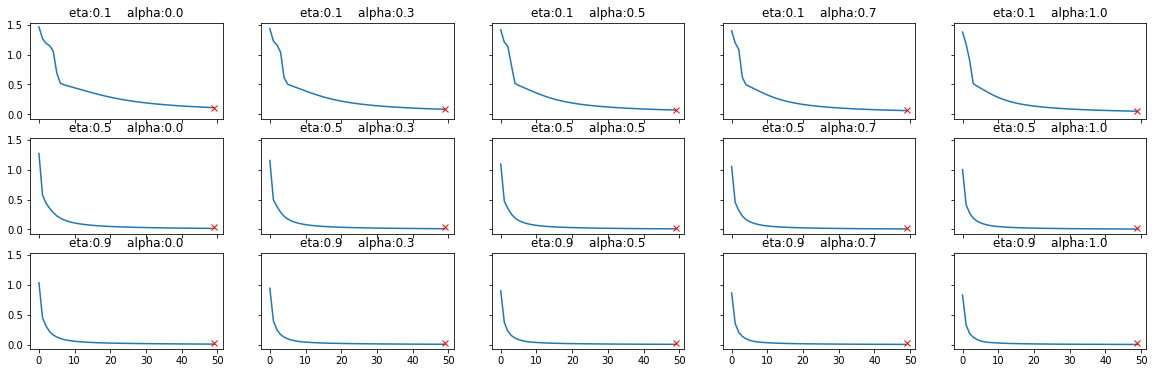

In [15]:
projeto(
    X_data = wine_X,
    y_data = wine_y,
    test_size = 0.6,
    eta = [0.1, 0.5, 0.9],
    alpha = [0, 0.3, 0.5, 0.7, 1],
    max_epocas = 50,
    n_intermed= 1,
    neur_intermed = 10,
    seed = 100
)

treino (142, 13) (142, 3)
teste (36, 13) (36, 3)
eta:0.1    alpha:0.0    MSE(treino):0.05440    MSE(teste):0.05971
eta:0.1    alpha:0.3    MSE(treino):0.04208    MSE(teste):0.04939
eta:0.1    alpha:0.5    MSE(treino):0.03665    MSE(teste):0.04503
eta:0.1    alpha:0.7    MSE(treino):0.03254    MSE(teste):0.04185
eta:0.1    alpha:1.0    MSE(treino):0.02786    MSE(teste):0.03825
eta:0.5    alpha:0.0    MSE(treino):0.01151    MSE(teste):0.02917
eta:0.5    alpha:0.3    MSE(treino):0.00897    MSE(teste):0.02840
eta:0.5    alpha:0.5    MSE(treino):0.00783    MSE(teste):0.02817
eta:0.5    alpha:0.7    MSE(treino):0.00696    MSE(teste):0.02813
eta:0.5    alpha:1.0    MSE(treino):0.00579    MSE(teste):0.02862
eta:0.9    alpha:0.0    MSE(treino):0.00671    MSE(teste):0.03128
eta:0.9    alpha:0.3    MSE(treino):0.00495    MSE(teste):0.03218
eta:0.9    alpha:0.5    MSE(treino):0.00415    MSE(teste):0.03318
eta:0.9    alpha:0.7    MSE(treino):0.00312    MSE(teste):0.03170
eta:0.9    alpha:1.0    MSE

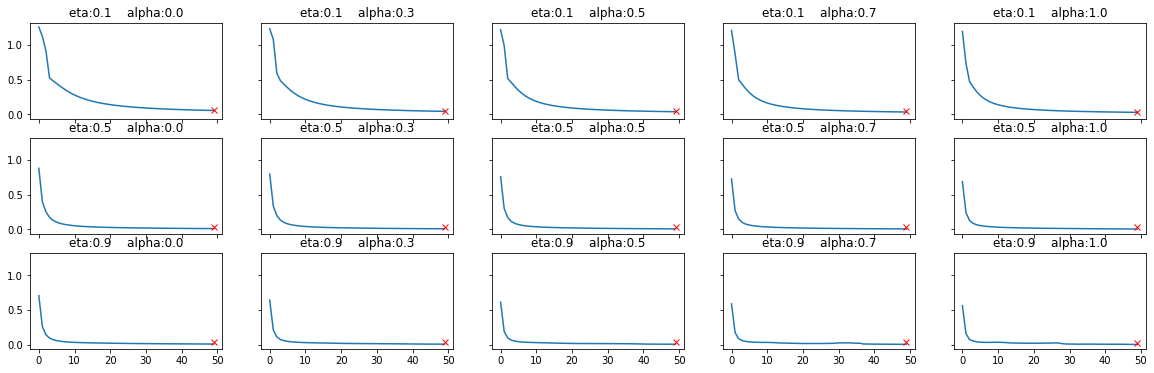

In [16]:
projeto(
    X_data = wine_X,
    y_data = wine_y,
    test_size = 0.2,
    eta = [0.1, 0.5, 0.9],
    alpha = [0, 0.3, 0.5, 0.7, 1],
    max_epocas = 50,
    n_intermed= 1,
    neur_intermed = 10,
    seed = 100
)

treino (71, 13) (71, 3)
teste (107, 13) (107, 3)
eta:0.1    alpha:0.0    MSE(treino):0.05037    MSE(teste):0.07506
eta:0.1    alpha:0.3    MSE(treino):0.03798    MSE(teste):0.06711
eta:0.1    alpha:0.5    MSE(treino):0.03295    MSE(teste):0.06345
eta:0.1    alpha:0.7    MSE(treino):0.02922    MSE(teste):0.06051
eta:0.1    alpha:1.0    MSE(treino):0.02503    MSE(teste):0.05698
eta:0.5    alpha:0.0    MSE(treino):0.00993    MSE(teste):0.04112
eta:0.5    alpha:0.3    MSE(treino):0.00767    MSE(teste):0.03856
eta:0.5    alpha:0.5    MSE(treino):0.00658    MSE(teste):0.03709
eta:0.5    alpha:0.7    MSE(treino):0.00637    MSE(teste):0.03644
eta:0.5    alpha:1.0    MSE(treino):0.00628    MSE(teste):0.03711
eta:0.9    alpha:0.0    MSE(treino):0.00517    MSE(teste):0.03839
eta:0.9    alpha:0.3    MSE(treino):0.00370    MSE(teste):0.03398
eta:0.9    alpha:0.5    MSE(treino):0.00243    MSE(teste):0.03364
eta:0.9    alpha:0.7    MSE(treino):0.00280    MSE(teste):0.03749
eta:0.9    alpha:1.0    MSE

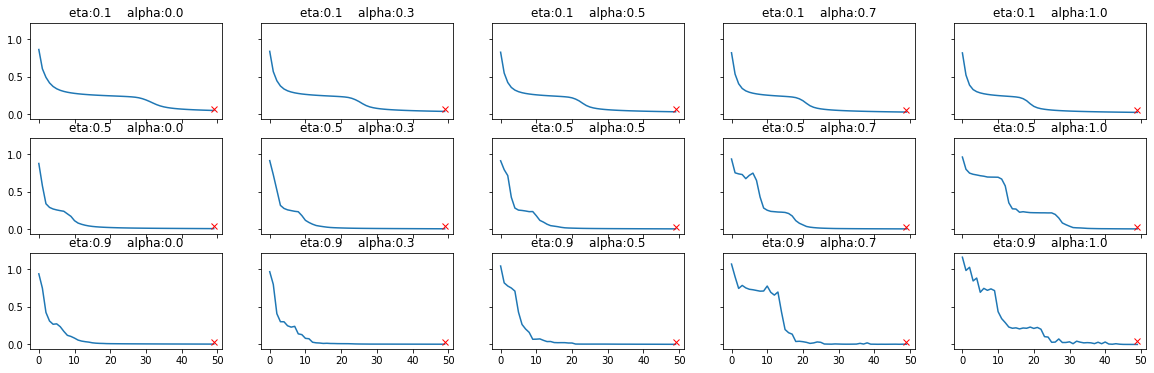

In [17]:
projeto(
    X_data = wine_X,
    y_data = wine_y,
    test_size = 0.6,
    eta = [0.1, 0.5, 0.9],
    alpha = [0, 0.3, 0.5, 0.7, 1],
    max_epocas = 50,
    n_intermed= 1,
    neur_intermed = 100,
    seed = 100
)

---
### 2 camadas

treino (71, 13) (71, 3)
teste (107, 13) (107, 3)
eta:0.1    alpha:0.0    MSE(treino):0.08679    MSE(teste):0.08794
eta:0.1    alpha:0.3    MSE(treino):0.05447    MSE(teste):0.06456
eta:0.1    alpha:0.5    MSE(treino):0.04224    MSE(teste):0.05721
eta:0.1    alpha:0.7    MSE(treino):0.03387    MSE(teste):0.05274
eta:0.1    alpha:1.0    MSE(treino):0.02556    MSE(teste):0.04876
eta:0.5    alpha:0.0    MSE(treino):0.00511    MSE(teste):0.04213
eta:0.5    alpha:0.3    MSE(treino):0.00300    MSE(teste):0.04292
eta:0.5    alpha:0.5    MSE(treino):0.00221    MSE(teste):0.04365
eta:0.5    alpha:0.7    MSE(treino):0.00169    MSE(teste):0.04440
eta:0.5    alpha:1.0    MSE(treino):0.00118    MSE(teste):0.04521
eta:0.9    alpha:0.0    MSE(treino):0.00145    MSE(teste):0.04448
eta:0.9    alpha:0.3    MSE(treino):0.00072    MSE(teste):0.04735
eta:0.9    alpha:0.5    MSE(treino):0.00050    MSE(teste):0.04693
eta:0.9    alpha:0.7    MSE(treino):0.00042    MSE(teste):0.04451
eta:0.9    alpha:1.0    MSE

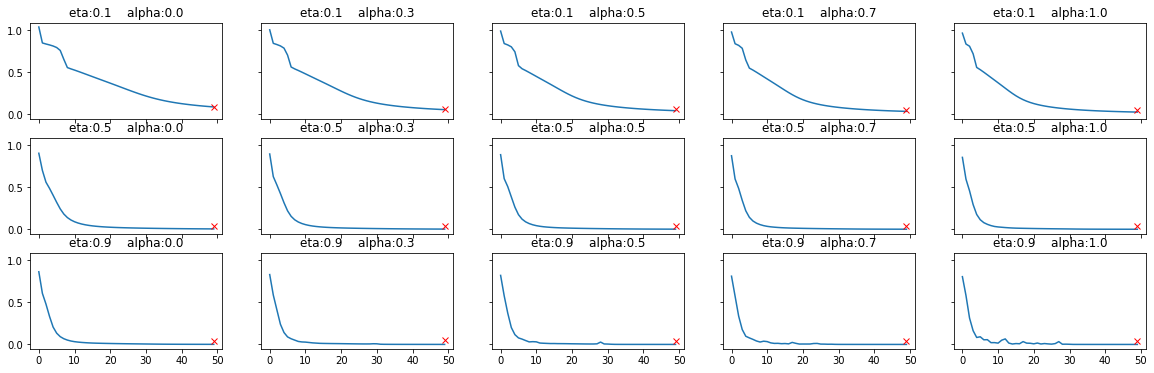

In [18]:
projeto(
    X_data = wine_X,
    y_data = wine_y,
    test_size = 0.6,
    eta = [0.1, 0.5, 0.9],
    alpha = [0, 0.3, 0.5, 0.7, 1],
    max_epocas = 50,
    n_intermed = 2,
    neur_intermed = 10,
    seed = 100
)

treino (142, 13) (142, 3)
teste (36, 13) (36, 3)
eta:0.1    alpha:0.0    MSE(treino):0.03449    MSE(teste):0.05161
eta:0.1    alpha:0.3    MSE(treino):0.02474    MSE(teste):0.04360
eta:0.1    alpha:0.5    MSE(treino):0.02068    MSE(teste):0.03988
eta:0.1    alpha:0.7    MSE(treino):0.01765    MSE(teste):0.03697
eta:0.1    alpha:1.0    MSE(treino):0.01426    MSE(teste):0.03356
eta:0.5    alpha:0.0    MSE(treino):0.00320    MSE(teste):0.02869
eta:0.5    alpha:0.3    MSE(treino):0.00148    MSE(teste):0.02775
eta:0.5    alpha:0.5    MSE(treino):0.00077    MSE(teste):0.02541
eta:0.5    alpha:0.7    MSE(treino):0.00045    MSE(teste):0.02615
eta:0.5    alpha:1.0    MSE(treino):0.00030    MSE(teste):0.02407
eta:0.9    alpha:0.0    MSE(treino):0.00049    MSE(teste):0.03105
eta:0.9    alpha:0.3    MSE(treino):0.00022    MSE(teste):0.02862
eta:0.9    alpha:0.5    MSE(treino):0.00015    MSE(teste):0.01308
eta:0.9    alpha:0.7    MSE(treino):0.00013    MSE(teste):0.02737
eta:0.9    alpha:1.0    MSE

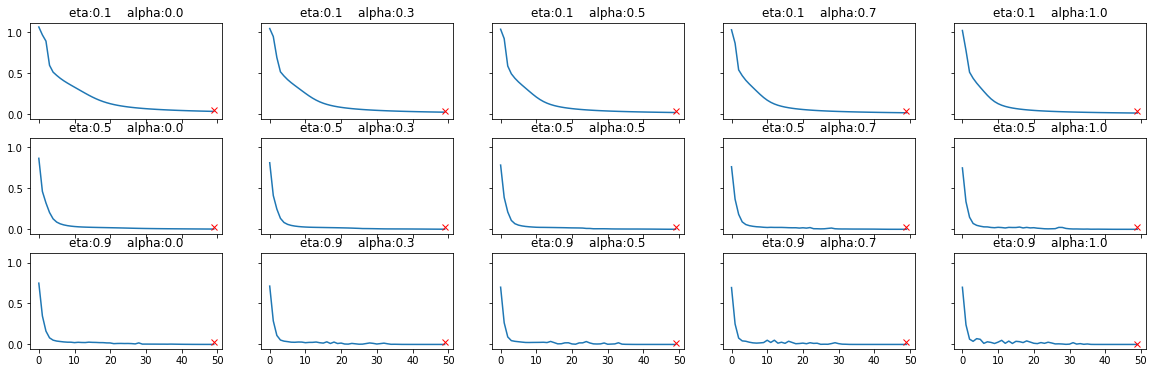

In [19]:
projeto(
    X_data = wine_X,
    y_data = wine_y,
    test_size = 0.2,
    eta = [0.1, 0.5, 0.9],
    alpha = [0, 0.3, 0.5, 0.7, 1],
    max_epocas = 50,
    n_intermed = 2,
    neur_intermed = 10,
    seed = 100
)

treino (142, 13) (142, 3)
teste (36, 13) (36, 3)
eta:0.1    alpha:0.0    MSE(treino):0.36535    MSE(teste):0.28917
eta:0.1    alpha:0.3    MSE(treino):0.36389    MSE(teste):0.28499
eta:0.1    alpha:0.5    MSE(treino):0.36317    MSE(teste):0.28342
eta:0.1    alpha:0.7    MSE(treino):0.36259    MSE(teste):0.28220
eta:0.1    alpha:1.0    MSE(treino):0.36191    MSE(teste):0.28041
eta:0.5    alpha:0.0    MSE(treino):0.00124    MSE(teste):0.05192
eta:0.5    alpha:0.3    MSE(treino):0.02227    MSE(teste):0.07596
eta:0.5    alpha:0.5    MSE(treino):0.02238    MSE(teste):0.08736
eta:0.5    alpha:0.7    MSE(treino):0.00014    MSE(teste):0.02886
eta:0.5    alpha:1.0    MSE(treino):0.00002    MSE(teste):0.04213
eta:0.9    alpha:0.0    MSE(treino):0.00001    MSE(teste):0.02991
eta:0.9    alpha:0.3    MSE(treino):0.00000    MSE(teste):0.02771
eta:0.9    alpha:0.5    MSE(treino):0.05465    MSE(teste):0.03797
eta:0.9    alpha:0.7    MSE(treino):1.00000    MSE(teste):1.00000
eta:0.9    alpha:1.0    MSE

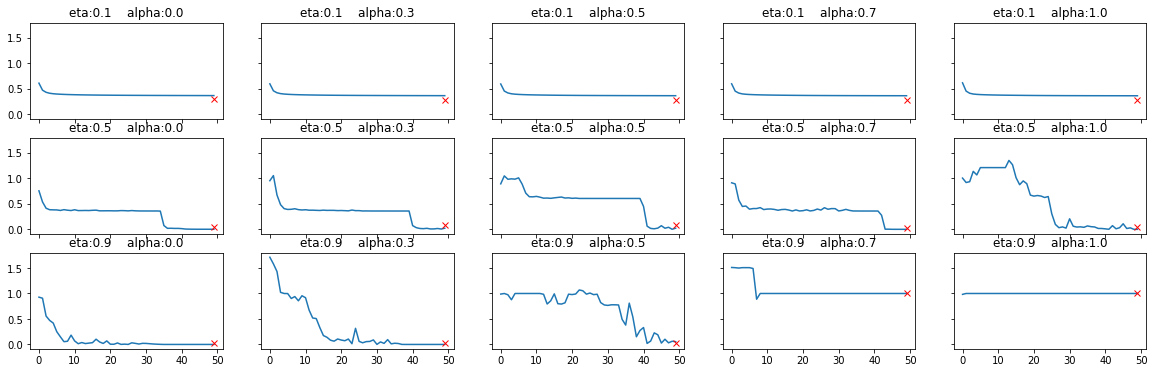

In [20]:
projeto(
    X_data = wine_X,
    y_data = wine_y,
    test_size = 0.2,
    eta = [0.1, 0.5, 0.9],
    alpha = [0, 0.3, 0.5, 0.7, 1],
    max_epocas = 50,
    n_intermed = 2,
    neur_intermed = 100,
    seed = 100
)

---
# Parte II - Regressão

## Tratamento Dados - Musica

As 68 primeiras colunas se referem a recursos de áudio da música, e as duas últimas se referem ao local de origem da música, representado pela latitude e longitude, respectivamente.

### Importando dados

In [21]:
# Carregando os dados em um dataframe
music_df = pd.read_csv('data/default_features_1059_tracks.txt', header=None)
music_df.head()

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
0,7.161286,7.835325,2.911583,0.984049,-1.499546,-2.094097,0.576000,-1.205671,1.849122,-0.425598,...,-1.504263,0.351267,-1.018726,-0.174878,-1.089543,-0.668840,-0.914772,-0.836250,-15.75,-47.95
1,0.225763,-0.094169,-0.603646,0.497745,0.874036,0.290280,-0.077659,-0.887385,0.432062,-0.093963,...,-0.495712,-0.465077,-0.157861,-0.157189,0.380951,1.088478,-0.123595,1.391141,14.91,-23.51
2,-0.692525,-0.517801,-0.788035,1.214351,-0.907214,0.880213,0.406899,-0.694895,-0.901869,-1.701574,...,-0.637167,0.147260,0.217914,2.718442,0.972919,2.081069,1.375763,1.063847,12.65,-8.00
3,-0.735562,-0.684055,2.058215,0.716328,-0.011393,0.805396,1.497982,0.114752,0.692847,0.052377,...,-0.178325,-0.065059,-0.724247,-1.020687,-0.751380,-0.385005,-0.012326,-0.392197,9.03,38.74
4,0.570272,0.273157,-0.279214,0.083456,1.049331,-0.869295,-0.265858,-0.401676,-0.872639,1.147483,...,-0.919463,-0.667912,-0.820172,-0.190488,0.306974,0.119658,0.271838,1.289783,34.03,-6.85


In [22]:
# Verificação de valores faltantes
# Retorna "True" caso haja pelo menos uma coluna com valores faltantes na base.
# Caso contrário, retorna "False"
any(music_df.isna().sum() > 0)

False

In [23]:
# Verificação de valores duplicados
# Retorna "True" caso haja pelo menos uma instância duplicada na base.
# Caso contrário, retorna "False"
any(music_df.duplicated())

False

---
### Normalização

In [24]:
music_scaler = MinMaxScaler()
music_norm = music_scaler.fit_transform(music_df)
music_norm = pd.DataFrame(music_norm)
music_norm.head()

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
0,0.792304,0.763528,0.554789,0.459774,0.332975,0.312870,0.694223,0.485061,0.772537,0.621409,...,0.010367,0.279176,0.059900,0.180836,0.046037,0.075438,0.046425,0.067519,0.217271,0.171557
1,0.160018,0.113349,0.072690,0.406624,0.751846,0.641129,0.601004,0.522885,0.619012,0.653455,...,0.122493,0.161148,0.146472,0.183240,0.260799,0.304061,0.166138,0.372358,0.558013,0.274298
2,0.076301,0.078613,0.047402,0.484945,0.437505,0.722346,0.670107,0.545760,0.474494,0.498113,...,0.106767,0.249681,0.184261,0.573916,0.347254,0.433194,0.393006,0.327565,0.532896,0.339499
3,0.072377,0.064981,0.437753,0.430514,0.595593,0.712046,0.825708,0.641975,0.647266,0.667595,...,0.157779,0.218983,0.089514,0.065927,0.095425,0.112365,0.182974,0.128292,0.492665,0.535985
4,0.191425,0.143468,0.117185,0.361344,0.782781,0.481490,0.574164,0.580605,0.477661,0.773414,...,0.075383,0.131821,0.079867,0.178716,0.249995,0.178020,0.225971,0.358486,0.770505,0.344333


---
### Separando X, y

In [25]:
# Separando os atributos
music_X = music_norm.drop(columns=[68,69])
music_y = music_norm[[68,69]]

In [26]:
music_X.head()

,0,1,2,3,4,5,6,7,8,9,...,58,59,60,61,62,63,64,65,66,67
0,0.792304,0.763528,0.554789,0.459774,0.332975,0.312870,0.694223,0.485061,0.772537,0.621409,...,0.080394,0.252689,0.010367,0.279176,0.059900,0.180836,0.046037,0.075438,0.046425,0.067519
1,0.160018,0.113349,0.072690,0.406624,0.751846,0.641129,0.601004,0.522885,0.619012,0.653455,...,0.213051,0.111763,0.122493,0.161148,0.146472,0.183240,0.260799,0.304061,0.166138,0.372358
2,0.076301,0.078613,0.047402,0.484945,0.437505,0.722346,0.670107,0.545760,0.474494,0.498113,...,0.102961,0.172823,0.106767,0.249681,0.184261,0.573916,0.347254,0.433194,0.393006,0.327565
3,0.072377,0.064981,0.437753,0.430514,0.595593,0.712046,0.825708,0.641975,0.647266,0.667595,...,0.101781,0.285450,0.157779,0.218983,0.089514,0.065927,0.095425,0.112365,0.182974,0.128292
4,0.191425,0.143468,0.117185,0.361344,0.782781,0.481490,0.574164,0.580605,0.477661,0.773414,...,0.198040,0.181444,0.075383,0.131821,0.079867,0.178716,0.249995,0.178020,0.225971,0.358486


In [27]:
music_y.head()

,68,69
0,0.217271,0.171557
1,0.558013,0.274298
2,0.532896,0.339499
3,0.492665,0.535985
4,0.770505,0.344333


In [28]:
music_X.describe()

,0,1,2,3,4,5,6,7,8,9,...,58,59,60,61,62,63,64,65,66,67
count,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,...,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000
mean,0.137675,0.119341,0.151387,0.347702,0.602079,0.601651,0.609058,0.629529,0.568848,0.660844,...,0.228568,0.263354,0.180476,0.231270,0.164924,0.207457,0.209170,0.165028,0.188380,0.185051
std,0.090064,0.080855,0.133417,0.107610,0.176360,0.137713,0.141061,0.119754,0.109147,0.098285,...,0.154851,0.158662,0.112526,0.146001,0.101449,0.135914,0.146102,0.130498,0.152983,0.137820
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.084041,0.070085,0.073296,0.282204,0.491777,0.513916,0.525338,0.562216,0.516567,0.617680,...,0.116240,0.146175,0.103242,0.130004,0.092673,0.114911,0.103892,0.077568,0.087802,0.091801
50%,0.122649,0.103749,0.114154,0.337469,0.625379,0.602785,0.617482,0.633383,0.580264,0.671376,...,0.187502,0.224180,0.154504,0.198967,0.144016,0.178620,0.170406,0.129550,0.137078,0.140347
75%,0.167894,0.146520,0.177241,0.402418,0.727464,0.692378,0.703896,0.696590,0.635436,0.717582,...,0.297618,0.345902,0.229485,0.298629,0.211424,0.269267,0.276279,0.204955,0.247677,0.230231
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [29]:
music_y.describe()

,68,69
count,1059.000000,1059.000000
mean,0.688501,0.534579
std,0.205150,0.211955
min,0.000000,0.000000
25%,0.555234,0.386624
50%,0.766393,0.511140
75%,0.835852,0.686733
max,1.000000,1.000000


---
## Aplicação

---
### 1 camada

treino (423, 68) (423, 2)
teste (636, 68) (636, 2)
eta:0.1    alpha:0.0    MSE(treino):0.08108    MSE(teste):0.07782
eta:0.1    alpha:0.3    MSE(treino):0.08003    MSE(teste):0.07685
eta:0.1    alpha:0.5    MSE(treino):0.07938    MSE(teste):0.07637
eta:0.1    alpha:0.7    MSE(treino):0.07873    MSE(teste):0.07598
eta:0.1    alpha:1.0    MSE(treino):0.07770    MSE(teste):0.07558
eta:0.5    alpha:0.0    MSE(treino):0.06952    MSE(teste):0.07424
eta:0.5    alpha:0.3    MSE(treino):0.06820    MSE(teste):0.07564
eta:0.5    alpha:0.5    MSE(treino):0.06775    MSE(teste):0.07722
eta:0.5    alpha:0.7    MSE(treino):0.06728    MSE(teste):0.07875
eta:0.5    alpha:1.0    MSE(treino):0.06591    MSE(teste):0.07859
eta:0.9    alpha:0.0    MSE(treino):0.06744    MSE(teste):0.08737
eta:0.9    alpha:0.3    MSE(treino):0.06516    MSE(teste):0.08663
eta:0.9    alpha:0.5    MSE(treino):0.06454    MSE(teste):0.07790
eta:0.9    alpha:0.7    MSE(treino):0.05990    MSE(teste):0.07117
eta:0.9    alpha:1.0    M

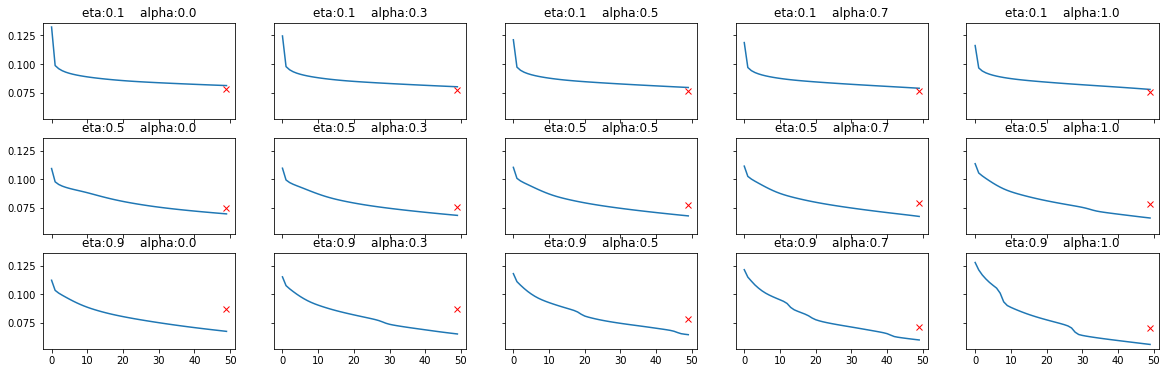

In [30]:
projeto(
    X_data = music_X,
    y_data = music_y,
    test_size = 0.6,
    eta = [0.1, 0.5, 0.9],
    alpha = [0, 0.3, 0.5, 0.7, 1],
    max_epocas = 50,
    n_intermed = 1,
    neur_intermed = 10,
    seed = 100
)

treino (847, 68) (847, 2)
teste (212, 68) (212, 2)
eta:0.1    alpha:0.0    MSE(treino):0.07506    MSE(teste):0.07219
eta:0.1    alpha:0.3    MSE(treino):0.07367    MSE(teste):0.07137
eta:0.1    alpha:0.5    MSE(treino):0.07294    MSE(teste):0.07090
eta:0.1    alpha:0.7    MSE(treino):0.07233    MSE(teste):0.07052
eta:0.1    alpha:1.0    MSE(treino):0.07157    MSE(teste):0.07016
eta:0.5    alpha:0.0    MSE(treino):0.06751    MSE(teste):0.06927
eta:0.5    alpha:0.3    MSE(treino):0.06703    MSE(teste):0.06896
eta:0.5    alpha:0.5    MSE(treino):0.06606    MSE(teste):0.06934
eta:0.5    alpha:0.7    MSE(treino):0.06349    MSE(teste):0.07020
eta:0.5    alpha:1.0    MSE(treino):0.06098    MSE(teste):0.07028
eta:0.9    alpha:0.0    MSE(treino):0.06456    MSE(teste):0.07040
eta:0.9    alpha:0.3    MSE(treino):0.05989    MSE(teste):0.07112
eta:0.9    alpha:0.5    MSE(treino):0.05748    MSE(teste):0.07038
eta:0.9    alpha:0.7    MSE(treino):0.05686    MSE(teste):0.07072
eta:0.9    alpha:1.0    M

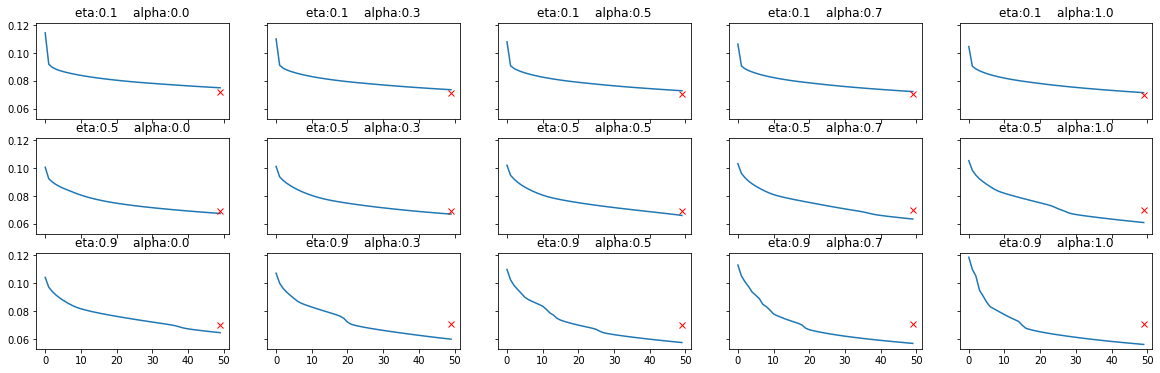

In [31]:
projeto(
    X_data = music_X,
    y_data = music_y,
    test_size = 0.2,
    eta = [0.1, 0.5, 0.9],
    alpha = [0, 0.3, 0.5, 0.7, 1],
    max_epocas = 50,
    n_intermed = 1,
    neur_intermed = 10,
    seed = 100
)

treino (847, 68) (847, 2)
teste (212, 68) (212, 2)
eta:0.1    alpha:0.0    MSE(treino):0.06181    MSE(teste):0.07816
eta:0.1    alpha:0.3    MSE(treino):0.06072    MSE(teste):0.07899
eta:0.1    alpha:0.5    MSE(treino):0.06028    MSE(teste):0.07992
eta:0.1    alpha:0.7    MSE(treino):0.05998    MSE(teste):0.08100
eta:0.1    alpha:1.0    MSE(treino):0.05969    MSE(teste):0.08277
eta:0.5    alpha:0.0    MSE(treino):0.05590    MSE(teste):0.09433
eta:0.5    alpha:0.3    MSE(treino):0.05192    MSE(teste):0.08972
eta:0.5    alpha:0.5    MSE(treino):0.04826    MSE(teste):0.08421
eta:0.5    alpha:0.7    MSE(treino):0.04716    MSE(teste):0.08200
eta:0.5    alpha:1.0    MSE(treino):0.04471    MSE(teste):0.07573
eta:0.9    alpha:0.0    MSE(treino):0.04625    MSE(teste):0.08398
eta:0.9    alpha:0.3    MSE(treino):0.04294    MSE(teste):0.07835
eta:0.9    alpha:0.5    MSE(treino):0.04221    MSE(teste):0.07881
eta:0.9    alpha:0.7    MSE(treino):0.04307    MSE(teste):0.07943
eta:0.9    alpha:1.0    M

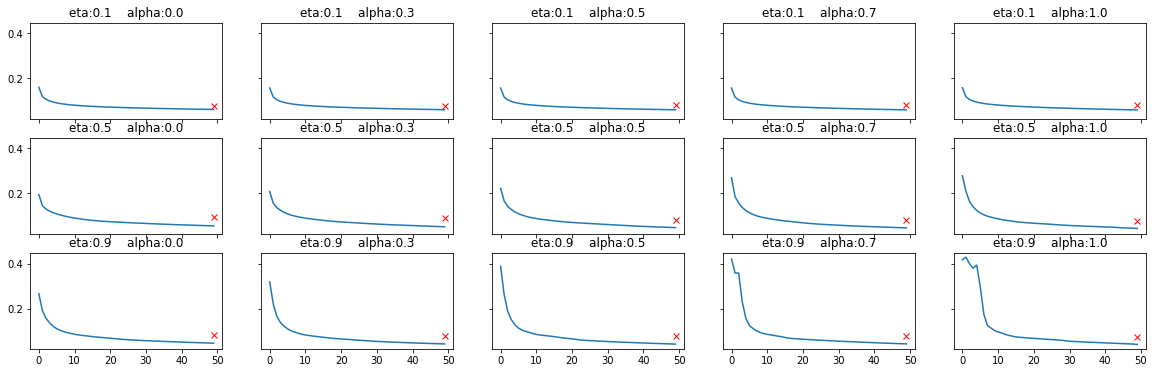

In [32]:
projeto(
    X_data = music_X,
    y_data = music_y,
    test_size = 0.2,
    eta = [0.1, 0.5, 0.9],
    alpha = [0, 0.3, 0.5, 0.7, 1],
    max_epocas = 50,
    n_intermed = 1,
    neur_intermed = 100,
    seed = 100
)

---
### 2 camadas

treino (423, 68) (423, 2)
teste (636, 68) (636, 2)
eta:0.1    alpha:0.0    MSE(treino):0.07757    MSE(teste):0.07767
eta:0.1    alpha:0.3    MSE(treino):0.07492    MSE(teste):0.07618
eta:0.1    alpha:0.5    MSE(treino):0.07345    MSE(teste):0.07532
eta:0.1    alpha:0.7    MSE(treino):0.07214    MSE(teste):0.07455
eta:0.1    alpha:1.0    MSE(treino):0.07051    MSE(teste):0.07376
eta:0.5    alpha:0.0    MSE(treino):0.06338    MSE(teste):0.07208
eta:0.5    alpha:0.3    MSE(treino):0.06039    MSE(teste):0.07164
eta:0.5    alpha:0.5    MSE(treino):0.05891    MSE(teste):0.07155
eta:0.5    alpha:0.7    MSE(treino):0.05762    MSE(teste):0.07161
eta:0.5    alpha:1.0    MSE(treino):0.05607    MSE(teste):0.07193
eta:0.9    alpha:0.0    MSE(treino):0.05755    MSE(teste):0.07187
eta:0.9    alpha:0.3    MSE(treino):0.05517    MSE(teste):0.07314
eta:0.9    alpha:0.5    MSE(treino):0.05412    MSE(teste):0.07459
eta:0.9    alpha:0.7    MSE(treino):0.05336    MSE(teste):0.07598
eta:0.9    alpha:1.0    M

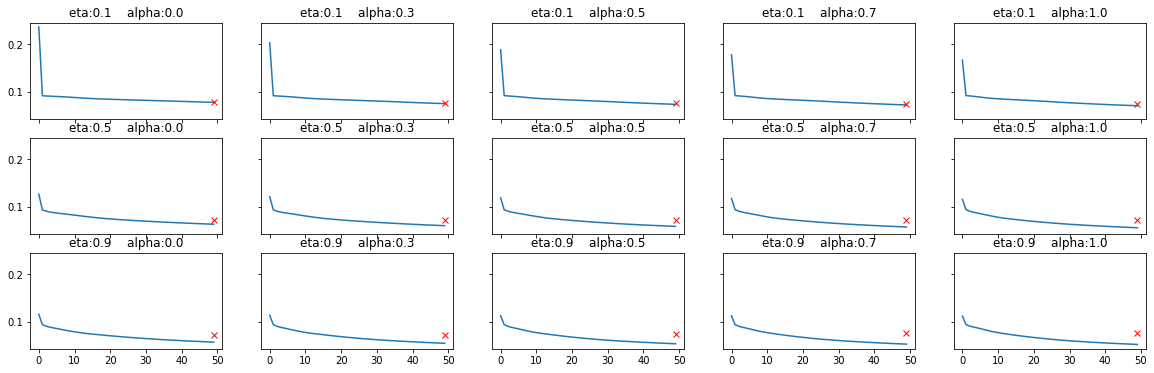

In [33]:
projeto(
    X_data = music_X,
    y_data = music_y,
    test_size = 0.6,
    eta = [0.1, 0.5, 0.9],
    alpha = [0, 0.3, 0.5, 0.7, 1],
    max_epocas = 50,
    n_intermed = 2,
    neur_intermed = 10,
    seed = 100
)

treino (847, 68) (847, 2)
teste (212, 68) (212, 2)
eta:0.1    alpha:0.0    MSE(treino):0.07326    MSE(teste):0.06974
eta:0.1    alpha:0.3    MSE(treino):0.07149    MSE(teste):0.06880
eta:0.1    alpha:0.5    MSE(treino):0.07049    MSE(teste):0.06842
eta:0.1    alpha:0.7    MSE(treino):0.06961    MSE(teste):0.06816
eta:0.1    alpha:1.0    MSE(treino):0.06844    MSE(teste):0.06786
eta:0.5    alpha:0.0    MSE(treino):0.06076    MSE(teste):0.06920
eta:0.5    alpha:0.3    MSE(treino):0.05898    MSE(teste):0.06994
eta:0.5    alpha:0.5    MSE(treino):0.05878    MSE(teste):0.06971
eta:0.5    alpha:0.7    MSE(treino):0.05892    MSE(teste):0.06935
eta:0.5    alpha:1.0    MSE(treino):0.05852    MSE(teste):0.06881
eta:0.9    alpha:0.0    MSE(treino):0.05926    MSE(teste):0.06985
eta:0.9    alpha:0.3    MSE(treino):0.05823    MSE(teste):0.07001
eta:0.9    alpha:0.5    MSE(treino):0.05780    MSE(teste):0.07058
eta:0.9    alpha:0.7    MSE(treino):0.05740    MSE(teste):0.07087
eta:0.9    alpha:1.0    M

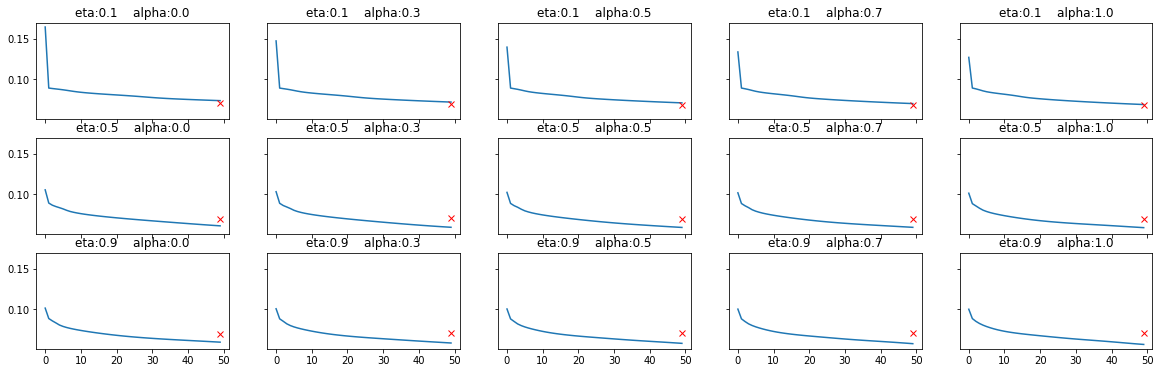

In [34]:
projeto(
    X_data = music_X,
    y_data = music_y,
    test_size = 0.2,
    eta = [0.1, 0.5, 0.9],
    alpha = [0, 0.3, 0.5, 0.7, 1],
    max_epocas = 50,
    n_intermed = 2,
    neur_intermed = 10,
    seed = 100
)

treino (847, 68) (847, 2)
teste (212, 68) (212, 2)
eta:0.1    alpha:0.0    MSE(treino):0.05853    MSE(teste):0.08593
eta:0.1    alpha:0.3    MSE(treino):0.05690    MSE(teste):0.09335
eta:0.1    alpha:0.5    MSE(treino):0.05646    MSE(teste):0.09273
eta:0.1    alpha:0.7    MSE(treino):0.05629    MSE(teste):0.09707
eta:0.1    alpha:1.0    MSE(treino):0.05696    MSE(teste):0.10453
eta:0.5    alpha:0.0    MSE(treino):0.05455    MSE(teste):0.13210
eta:0.5    alpha:0.3    MSE(treino):0.05651    MSE(teste):0.10739
eta:0.5    alpha:0.5    MSE(treino):0.05819    MSE(teste):0.14794
eta:0.5    alpha:0.7    MSE(treino):0.06041    MSE(teste):0.13123
eta:0.5    alpha:1.0    MSE(treino):0.05370    MSE(teste):0.12711
eta:0.9    alpha:0.0    MSE(treino):0.06162    MSE(teste):0.13748
eta:0.9    alpha:0.3    MSE(treino):0.06835    MSE(teste):0.15382
eta:0.9    alpha:0.5    MSE(treino):0.05668    MSE(teste):0.10995
eta:0.9    alpha:0.7    MSE(treino):0.06681    MSE(teste):0.12573
eta:0.9    alpha:1.0    M

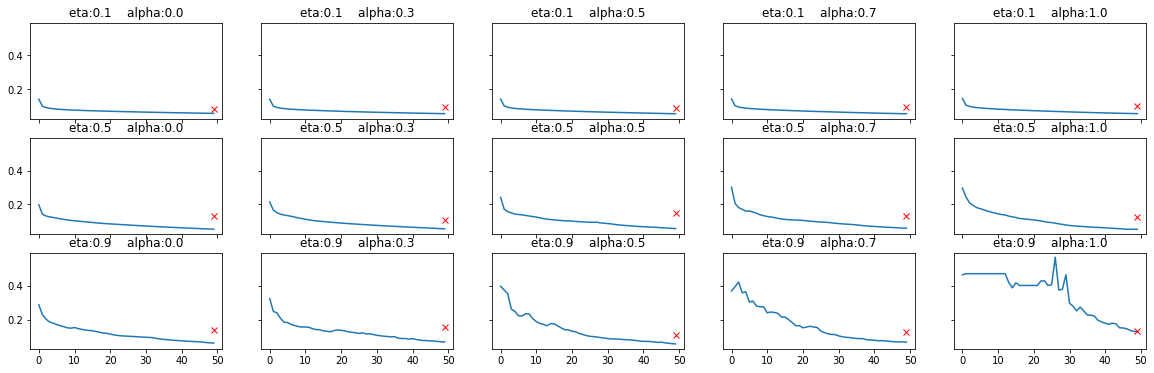

In [35]:
projeto(
    X_data = music_X,
    y_data = music_y,
    test_size = 0.2,
    eta = [0.1, 0.5, 0.9],
    alpha = [0, 0.3, 0.5, 0.7, 1],
    max_epocas = 50,
    n_intermed = 2,
    neur_intermed = 100,
    seed = 100
)

treino (847, 68) (847, 2)
teste (212, 68) (212, 2)
eta:0.1    alpha:0.0    MSE(treino):0.04512    MSE(teste):0.08950
eta:0.1    alpha:0.3    MSE(treino):0.04230    MSE(teste):0.09784
eta:0.1    alpha:0.5    MSE(treino):0.04069    MSE(teste):0.09845
eta:0.1    alpha:0.7    MSE(treino):0.03976    MSE(teste):0.10228
eta:0.1    alpha:1.0    MSE(treino):0.03874    MSE(teste):0.11008
eta:0.5    alpha:0.0    MSE(treino):0.02618    MSE(teste):0.12436
eta:0.5    alpha:0.3    MSE(treino):0.02758    MSE(teste):0.14584
eta:0.5    alpha:0.5    MSE(treino):0.02909    MSE(teste):0.12489
eta:0.5    alpha:0.7    MSE(treino):0.02821    MSE(teste):0.10933
eta:0.5    alpha:1.0    MSE(treino):0.02676    MSE(teste):0.12372
eta:0.9    alpha:0.0    MSE(treino):0.02688    MSE(teste):0.13734
eta:0.9    alpha:0.3    MSE(treino):0.03205    MSE(teste):0.12657
eta:0.9    alpha:0.5    MSE(treino):0.02388    MSE(teste):0.11201
eta:0.9    alpha:0.7    MSE(treino):0.02740    MSE(teste):0.12160
eta:0.9    alpha:1.0    M

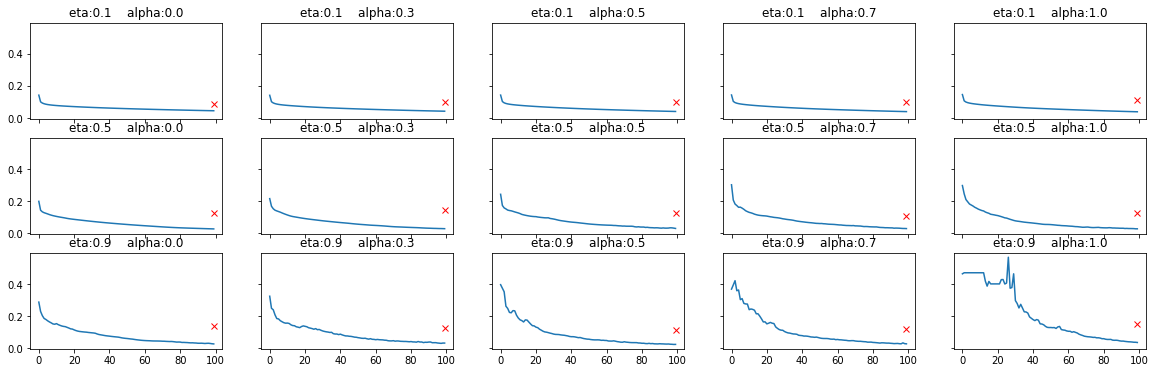

In [37]:
projeto(
    X_data = music_X,
    y_data = music_y,
    test_size = 0.2,
    eta = [0.1, 0.5, 0.9],
    alpha = [0, 0.3, 0.5, 0.7, 1],
    max_epocas = 100,
    n_intermed = 2,
    neur_intermed = 100,
    seed = 100
)